In [3]:
# -*- coding: utf-8 -*- 
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the Simargl 2022 dataset. 
# implemented a MplClassifier using a simple neural network. 

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
import tensorflow as tf
import seaborn as sns

In [4]:
# Load the cleaned Simargl 2022 dataset
df = pd.read_csv(
    '/home/ibibers@ads.iu.edu/IDS_Datasets/Combined_datasets/Simargl_cleaned_dataset.csv')

In [5]:
# Extract subsample of data
print (" Extract subsample of data: ")
print(df['ALERT'].value_counts())

 Extract subsample of data: 
ALERT
Normal               15049330
Denial of Service     5138973
Port Scanning         4170194
Malware                   571
Name: count, dtype: int64


In [6]:
dropped_df = ['ALERT']
X = df.drop(dropped_df, axis=1)
y = df['ALERT']

# Label encoding for the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print(df['ALERT'].value_counts())

ALERT
Normal               15049330
Denial of Service     5138973
Port Scanning         4170194
Malware                   571
Name: count, dtype: int64


In [7]:
# Initial train test split set and split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize MirroredStrategy for GPU acceleration
strategy = tf.distribute.MirroredStrategy()

# Train the models
with strategy.scope():
    # initialization for MLPClassifier
    nn_model = MLPClassifier(
        hidden_layer_sizes=(50, 50),  # Adjust the number of neurons in hidden layers as needed
        activation='relu',            # Rectified Linear Unit (ReLU) activation function
        solver='adam',                # Adam optimizer
        alpha=0.0001,                  # L2 regularization term
        batch_size='auto',             # Auto-adjust batch size based on the size of the dataset
        learning_rate='constant',      # Constant learning rate
        learning_rate_init=0.001,      # Initial learning rate
        max_iter=1000,                 # Maximum number of iterations
        random_state=42,               # Random seed for reproducibility
        early_stopping=False,          # Disable early stopping
        verbose=True                   # Print progress messages during training
    )
    
    # Train the Decision Tree model
    nn_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_encoded = nn_model.predict(X_test)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2024-02-27 16:34:19.572156: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45551 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:67:00.0, compute capability: 8.6
2024-02-27 16:34:19.573592: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 45492 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:68:00.0, compute capability: 8.6


Iteration 1, loss = 4.78627211
Iteration 2, loss = 0.93374244
Iteration 3, loss = 0.92984135
Iteration 4, loss = 0.92824075
Iteration 5, loss = 0.92822242
Iteration 6, loss = 0.92822159
Iteration 7, loss = 0.92822179
Iteration 8, loss = 0.92822120
Iteration 9, loss = 0.92822089
Iteration 10, loss = 0.92822078
Iteration 11, loss = 0.92822202
Iteration 12, loss = 0.92822223
Iteration 13, loss = 0.92822003
Iteration 14, loss = 0.92822142
Iteration 15, loss = 0.92821967
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [8]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6178121742743052


In [9]:
# Use inverse_transform to get original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_test_labels = label_encoder.inverse_transform(y_test)

In [10]:
#  Classificaiton Report 
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))


Classification Report:


/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

Denial of Service       0.00      0.00      0.00   1027795
          Malware       0.00      0.00      0.00       114
           Normal       0.62      1.00      0.76   3009866
    Port Scanning       0.00      0.00      0.00    834039

         accuracy                           0.62   4871814
        macro avg       0.15      0.25      0.19   4871814
     weighted avg       0.38      0.62      0.47   4871814



/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


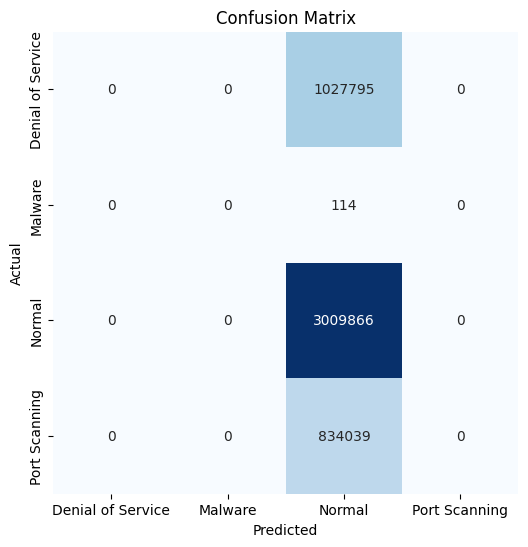

In [13]:
import numpy as np
# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test_labels, y_pred)

# Get unique class labels from y_test and y_pred_encoded
unique_labels = np.unique(np.concatenate((y_test_labels, y_pred)))

# Plotting the Confusion Matrix with class labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/tmp/ipykernel_2032048/3736126712.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sorted_importance.values()), y=list(


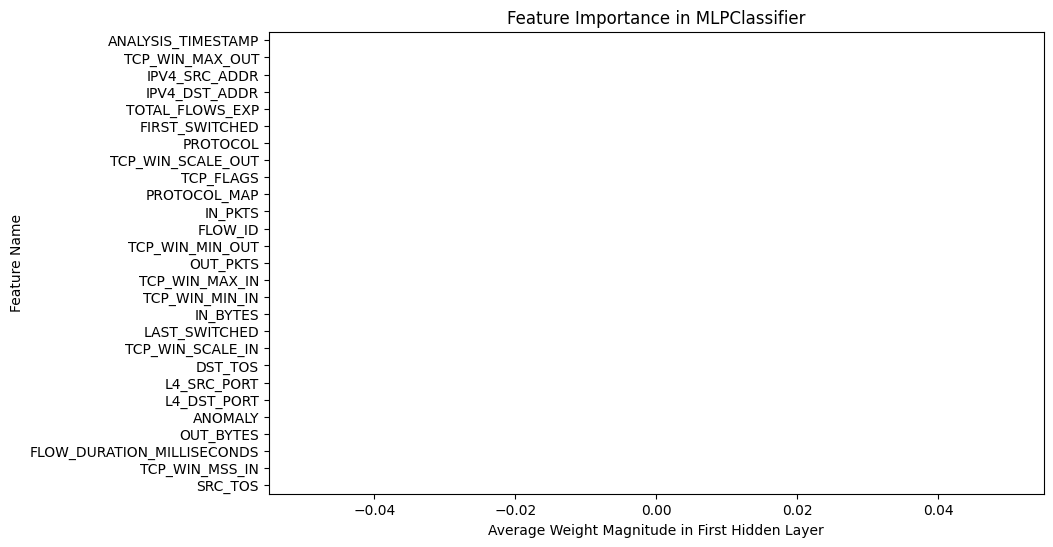

In [14]:
# Extract weights from the first hidden layer
weights_first_hidden_layer = nn_model.coefs_[0]

# Calculate feature importance based on the weights
feature_importance = np.abs(weights_first_hidden_layer).mean(axis=0)

# Create a DataFrame for visualization
importance_dict = dict(zip(X.columns.values, feature_importance))
sorted_importance = dict(
    sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

# Visualize the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=list(sorted_importance.values()), y=list(
    sorted_importance.keys()), palette='mako')
plt.xlabel('Average Weight Magnitude in First Hidden Layer')
plt.ylabel('Feature Name')
plt.title('Feature Importance in MLPClassifier')
plt.show()